In [28]:
%load_ext watermark


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [30]:
watermark

2018-06-20T09:36:51-07:00

CPython 3.6.1
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [29]:
watermark -p pandas,numpy,scipy,matplotlib

pandas 0.23.1
numpy 1.14.2
scipy 1.1.0
matplotlib 2.0.2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad

# Determing Statistical Limit of Entropy Detection Methods
<informal abstract>


## Introduction to Agnentroscan (entropy based transform)

In our case, the term entropy is simply a measure of information content. Agnentroscan is dervied from the Jensen-Shannon divergence (JSD). Typically, JSD quanitfies the total information distance between a pair of probability distributions by computing pairwise distances measures. The closer JSD is to zero, the more "similar" the two probablity distributions are. Jensen-Shannon Exodivergance Transform (JSET), which is a entropy based transform, uses JSD in a manner that can apply to SETI data. 

At SETI, we typically sweep across a datafile trying to extract an anomolous signal amongst another signals or noise. For this analysis, we will call the signal we wish to extract the "needle" and the full data file of signals and noise the "haystack" and the sweeping window of the scan the "sweep."

So JSET simply takes the JSD between what is in the sweep and everything in the haystack outside the sweep (the exo-sweep) as the sweep scnas the full dataset. JSET quanitfies the "difference" between the probability distribution of the sweep and the exosweep, so has the ability to report which sweep window was the "most different" from its exo-sweep and the window's relative entropy. The intution is that the sweep window with the greatest entropy or at the greatest information distance from its exosweep might be an anomolous signal. 

What we end up using in this analysis is the Leidich Exodivergance Transform (LET) which slightly modfied version of JSET. JSD assigned equal weight to each proabability distribution which is suboptimal in our case since the sampe size of the sweep is almost always smaller than the size of the haystack. Leidich Exodivergance (LD) assigns weight for each distribution based on sample size to arrive at a more accurate valuation of the informaiton contained in each distribution. LET uses LD instead of JSD.

Note that agnentroscan, LD, and LET are all created by Russell Leidich. This is only a high level introducion to agnentroscan written for this analysis, please take the visit Russell's [blog](https://agnentropy.blogspot.com/), read his [paper](http://vixra.org/pdf/1710.0261v2.pdf) and checkout agnentro on [github](https://github.com/egione/Agnentro) to learn more about agnostic entropy. 

## Testing the power of Agnentroscan (Methodology)
We wanted to determine the statistical limits of LET and compare it's detection capbilities with SETI's current power detector method.

To do so, we ran agnentroscan and power detector method on 1000s of simulated haystacks. Each haystacks had 1M smaples of gusassian noise at a fixed $\sigma$ of 10. In some haystacks we injected a 250K smaple needle (25% duty cycle) at a random point in the guassian noise. Needles were sinusodial and linear chirps are differnet magnitudes to create differnet haystacks at differnet signal to noise ratios (SNR).

![image.png](sample_images/haystack_components.png)
 
So, 1000 haystacks of just noise, noise + sine, and noise + chirp were created at db SNR levels of -15, -13, -11, -10, -5. Each needle has a random phase, a random frequency and is injected at random points in the each haystack. Below is a visualization of a haystack with a strong linear chirp injected. The right most is 1M samples of the haystack plotted across all time. THe middle plot is a spectrogram of the signal where you can see frequency of the linera chirp amonst background noise. The leftmost is a histogram of the haystack which looks roughly guassian-ish.

![strong_chirp_example](sample_images/strongchirp_example.png)

The idea was that agnentroscan would slide a sweep across each haystack at be able to find the start sample of the window(s) containing the injected signal and report the entropy. For the noise haystacks, agnentroscan would also report a "most different" window and its relative entropy, but this entropy metric would a lot higher which both the sweep and exo-sweep came from the same distribution (Note: we expect entropy of noise to be higher because LET report 1-LD, closeness to 1 implies greater similarity to exo-sweep).

Finally, we plotted the entropy distributions of just noise and noise + needle and create the ROC to determine how good detector the entopry method was for that needle type at that SNR. We could then compare the entropy ROC to the power detector ROC. (Note: again for the entropy detector, the noise distribution will have higher entropy so position of the below curves will be swapped)

![distr](sample_images/noise_needle_distributions.png)



## Sweep Size Test

Before beginning our analysis, we were curious how the sweep size window relative to the duty cycle would affect agnentro's entropy metrics. We ran a monte carlo simulation by fixing the duty cycle and exponentially increasing the window size and reporting the distribution of entropies agnentro outputted. This was ran several times across a wide range of SNRs. Here are the results from a fixed duty cycle of 25%, meaning the inject needle was 25% of the totoal haystack (250K smaples of needle in a 1M sample haystack).(Note: the final plot is just a noise haystack)
![25%dc](sweep_test_results/25dc_i__plot.png)

Here is the same test at a 50% duty cycle.(Note: the final plot is just a noise haystack)
![50%dc](sweep_test_results/50dc_i__plot.png)

It seems like there is general trend slightly increasing entropy output as you increase the size of the sweep. At higher SNR level, the entropy outputs are lowest when the sweep as approximately the size of the duty cycle. So at high SNRs, the entropy scan is best at detecting an injected needle if the sweep window is the same size as the duty cycle.

For our analysis, we'll set our sweep to be the same size as the study cycle (250K samples). However we are working with relatively low SNRs, so this is not likely to improve performance.

## Entropy Scan Results & ROC Curves
### SNR = -5db Results
Here are the entropy scan results at -5db SNR for a sine needle.
![sineat-5](scan_results/-5db_i_sine_plots.png)

The top plot the distribution of normalized entropy (b/w 0 an 1) outputted by the LET scan. The blue represents haystacks with sine needles injected in guassian noise and the orange represenets just gussian noise haystacks at 10 $\sigma$. The middle plot is a zoomed in version of the overlap inbetween the two distributions and in this case there is no overlap. The LET scan is a great detector for sine needles at -5db. The bottom left plot is just the sine haystack entropy distribution and bottom right is just the noise haystack entropy distribution.

Here are the entropy scan resutls at -5db SNR for a chirp needle.
![sineat-5](scan_results/-5db_i_chirp_plots.png)

Again, there is no overlap making the LET scan a great detector for linear chirps at -5 db. We can plot the ROC curves for each type of needle at -5db SNR.

In [3]:
df = pd.read_csv('scan_results/-5db_i_results.csv', index_col=0)

sine_dist = df.loc[df.NeedleType =='sine']['norm_entropy']
min_sine = df.loc[df.NeedleType =='sine']['norm_entropy'].min()
max_sine = df.loc[df.NeedleType =='sine']['norm_entropy'].max()

chirp_dist = df.loc[df.NeedleType =='chirp']['norm_entropy']
min_chirp = df.loc[df.NeedleType =='chirp']['norm_entropy'].min()
max_chirp = df.loc[df.NeedleType =='chirp']['norm_entropy'].max()

noise_dist = df.loc[df.NeedleType =='noise']['norm_entropy']
min_noise = df.loc[df.NeedleType =='noise']['norm_entropy'].min()
max_noise = df.loc[df.NeedleType =='noise']['norm_entropy'].max()

mu_sine, std_sine = norm.fit(sine_dist)
mu_chirp, std_chirp = norm.fit(chirp_dist)
mu_noise, std_noise = norm.fit(noise_dist)

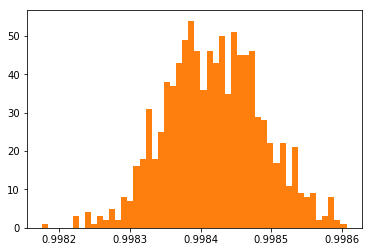

In [36]:
sine_yvals, xvals = plt.hist(sine_dist, bins=50)[0], plt.hist(sine_dist, bins=50)[1]

In [37]:
xvals =  xvals[:-1]

In [55]:
print(mu_sine, std_sine)

0.9984189711319557 6.820512564062891e-05


[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 801
    # data points      = 50
    # variables        = 4
    chi-square         = 1120.12194
    reduced chi-square = 24.3504769
    Akaike info crit   = 163.458491
    Bayesian info crit = 171.106583
[[Variables]]
    gamma:      1.14789252 +/- 0.52244128 (45.51%) (init = 0)
    sigma:      8.9587e-05 +/- 1.1887e-05 (13.27%) (init = 1)
    center:     0.99836242 +/- 1.4481e-05 (0.00%) (init = 0)
    amplitude:  0.00873354 +/- 2.8544e-04 (3.27%) (init = 10)
    height:     38.8914303 +/- 4.96407690 (12.76%) == '0.3989423*amplitude/max(1.e-15, sigma)'
    fwhm:       2.1096e-04 +/- 2.7991e-05 (13.27%) == '2.3548200*sigma'
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, center)     = -0.977
    C(sigma, center)     = -0.968
    C(gamma, sigma)      =  0.958
    C(sigma, amplitude)  =  0.275
    C(center, amplitude) = -0.176
    C(gamma, amplitude)  =  0.

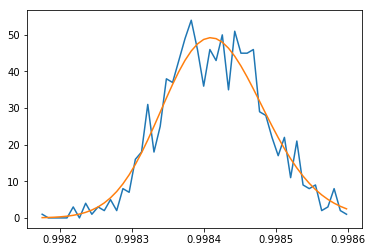

In [39]:
from lmfit.models import SkewedGaussianModel

model = SkewedGaussianModel()

# set initial parameter values
params = model.make_params(amplitude=10, center=0, sigma=1, gamma=0)

# adjust parameters  to best fit data.
result = model.fit(yvals, params, x=xvals)

print(result.fit_report())
plt.plot(xvals, yvals)
plt.plot(xvals, result.best_fit) 

In [58]:
result.eval(x=0.9984)

48.7884770082171

In [59]:
sine_thres = np.linspace(min_sine, max_sine, 20)
sine_p_d = []
sine_p_fa = []
for thres in sine_thres:
    a = min_sine
    b = thres
    sine_p_d.append(quad(lambda x: result.eval(x=x), a, b)[0])
    sine_p_fa.append(quad(lambda x: norm.pdf(x, loc = mu_noise, scale = std_noise), a, b)[0])

chirp_thres = np.linspace(min_chirp, max_chirp, 20)
chirp_p_d = []
chirp_p_fa = []
for thres in chirp_thres:
    a = min_chirp
    b = thres
    chirp_p_d.append(quad(lambda x: norm.pdf(x, loc = mu_chirp, scale = std_chirp), a, b)[0])
    chirp_p_fa.append(quad(lambda x: norm.pdf(x, loc = mu_chirp, scale = std_chirp), a, b)[0])


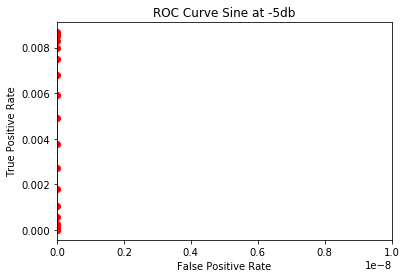

In [60]:
plt.plot(sine_p_fa, sine_p_d, '-o', color="red");
plt.xlim((0, 0.00000001));
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve Sine at -5db');


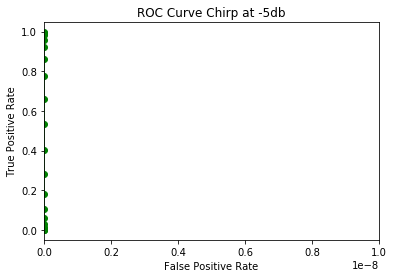

In [7]:
plt.plot(sine_p_fa, sine_p_d, '-o', color='green');
plt.xlim((0, 0.00000001));
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve Chirp at -5db');

There is no overlap between the haystacks with needles and the noise only haystacks, so there the ROC curves show no false positives. Let's make the needle even weaker (decrease SNR) and see how the entropy distributions change.

### SNR = -10db Results
Here are the entropy scan results at -10db SNR for a sine needle.
![sineat-10](scan_results/-10db_i_sine_plots.png)

Here are the entropy scan results at -10db SNR for a sine needle.
![chirpat-10](scan_results/-10db_i_chirp_plots.png)

In [8]:
df = pd.read_csv('scan_results/-10db_i_results.csv', index_col=0)

sine_dist = df.loc[df.NeedleType =='sine']['norm_entropy']
min_sine = df.loc[df.NeedleType =='sine']['norm_entropy'].min()
max_sine = df.loc[df.NeedleType =='sine']['norm_entropy'].max()

chirp_dist = df.loc[df.NeedleType =='chirp']['norm_entropy']
min_chirp = df.loc[df.NeedleType =='chirp']['norm_entropy'].min()
max_chirp = df.loc[df.NeedleType =='chirp']['norm_entropy'].max()

noise_dist = df.loc[df.NeedleType =='noise']['norm_entropy']
min_noise = df.loc[df.NeedleType =='noise']['norm_entropy'].min()
max_noise = df.loc[df.NeedleType =='noise']['norm_entropy'].max()

mu_sine, std_sine = norm.fit(sine_dist)
mu_chirp, std_chirp = norm.fit(chirp_dist)
mu_noise, std_noise = norm.fit(noise_dist)

In [9]:
sine_thres = np.linspace(min_sine, max_sine, 20)
sine_p_d = []
sine_p_fa = []
for thres in sine_thres:
    a = min_sine
    b = thres
    sine_p_d.append(quad(lambda x: norm.pdf(x, loc = mu_sine, scale = std_sine), a, b)[0])
    sine_p_fa.append(quad(lambda x: norm.pdf(x, loc = mu_noise, scale = std_noise), a, b)[0])

chirp_thres = np.linspace(min_chirp, max_chirp, 20)
chirp_p_d = []
chirp_p_fa = []
for thres in chirp_thres:
    a = min_chirp
    b = thres
    chirp_p_d.append(quad(lambda x: norm.pdf(x, loc = mu_chirp, scale = std_chirp), a, b)[0])
    chirp_p_fa.append(quad(lambda x: norm.pdf(x, loc = mu_chirp, scale = std_chirp), a, b)[0])


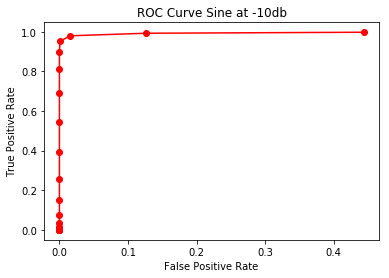

In [10]:
plt.plot(sine_p_fa, sine_p_d, '-o', color="red");
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve Sine at -10db');


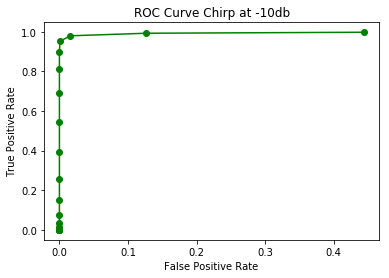

In [11]:
plt.plot(sine_p_fa, sine_p_d, '-o', color='green');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve Chirp at -10db');

### SNR = -11db Results
Here are the entropy scan results at -11db SNR for a sine needle.
![sineat-11](scan_results/-11db_i_sine_plots.png)

Here are the entropy scan results at -11db SNR for a sine needle.
![chirpat-11](scan_results/-11db_i_chirp_plots.png)

In [12]:
df = pd.read_csv('scan_results/-11db_i_results.csv', index_col=0)

sine_dist = df.loc[df.NeedleType =='sine']['norm_entropy']
min_sine = df.loc[df.NeedleType =='sine']['norm_entropy'].min()
max_sine = df.loc[df.NeedleType =='sine']['norm_entropy'].max()

chirp_dist = df.loc[df.NeedleType =='chirp']['norm_entropy']
min_chirp = df.loc[df.NeedleType =='chirp']['norm_entropy'].min()
max_chirp = df.loc[df.NeedleType =='chirp']['norm_entropy'].max()

noise_dist = df.loc[df.NeedleType =='noise']['norm_entropy']
min_noise = df.loc[df.NeedleType =='noise']['norm_entropy'].min()
max_noise = df.loc[df.NeedleType =='noise']['norm_entropy'].max()

mu_sine, std_sine = norm.fit(sine_dist)
mu_chirp, std_chirp = norm.fit(chirp_dist)
mu_noise, std_noise = norm.fit(noise_dist)

In [13]:
sine_thres = np.linspace(min_sine, max_sine, 20)
sine_p_d = []
sine_p_fa = []
for thres in sine_thres:
    a = min_sine
    b = thres
    sine_p_d.append(quad(lambda x: norm.pdf(x, loc = mu_sine, scale = std_sine), a, b)[0])
    sine_p_fa.append(quad(lambda x: norm.pdf(x, loc = mu_noise, scale = std_noise), a, b)[0])

chirp_thres = np.linspace(min_chirp, max_chirp, 20)
chirp_p_d = []
chirp_p_fa = []
for thres in chirp_thres:
    a = min_chirp
    b = thres
    chirp_p_d.append(quad(lambda x: norm.pdf(x, loc = mu_chirp, scale = std_chirp), a, b)[0])
    chirp_p_fa.append(quad(lambda x: norm.pdf(x, loc = mu_chirp, scale = std_chirp), a, b)[0])


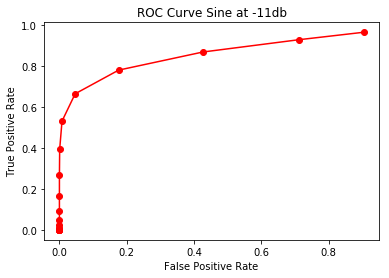

In [14]:
plt.plot(sine_p_fa, sine_p_d, '-o', color="red");
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve Sine at -11db');


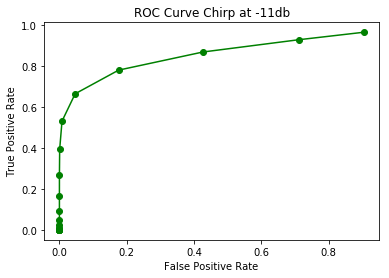

In [15]:
plt.plot(sine_p_fa, sine_p_d, '-o', color='green');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve Chirp at -11db');

### SNR = -12db Results
Here are the entropy scan results at -12db SNR for a sine needle.
![sineat-12](scan_results/-12db_i_sine_plots.png)

Here are the entropy scan results at -12db SNR for a sine needle.
![chirpat-12](scan_results/-12db_i_chirp_plots.png)

In [16]:
df = pd.read_csv('scan_results/-12db_i_results.csv', index_col=0)

sine_dist = df.loc[df.NeedleType =='sine']['norm_entropy']
min_sine = df.loc[df.NeedleType =='sine']['norm_entropy'].min()
max_sine = df.loc[df.NeedleType =='sine']['norm_entropy'].max()

chirp_dist = df.loc[df.NeedleType =='chirp']['norm_entropy']
min_chirp = df.loc[df.NeedleType =='chirp']['norm_entropy'].min()
max_chirp = df.loc[df.NeedleType =='chirp']['norm_entropy'].max()

noise_dist = df.loc[df.NeedleType =='noise']['norm_entropy']
min_noise = df.loc[df.NeedleType =='noise']['norm_entropy'].min()
max_noise = df.loc[df.NeedleType =='noise']['norm_entropy'].max()

mu_sine, std_sine = norm.fit(sine_dist)
mu_chirp, std_chirp = norm.fit(chirp_dist)
mu_noise, std_noise = norm.fit(noise_dist)

In [17]:
sine_thres = np.linspace(min_sine, max_sine, 20)
sine_p_d = []
sine_p_fa = []
for thres in sine_thres:
    a = min_sine
    b = thres
    sine_p_d.append(quad(lambda x: norm.pdf(x, loc = mu_sine, scale = std_sine), a, b)[0])
    sine_p_fa.append(quad(lambda x: norm.pdf(x, loc = mu_noise, scale = std_noise), a, b)[0])

chirp_thres = np.linspace(min_chirp, max_chirp, 20)
chirp_p_d = []
chirp_p_fa = []
for thres in chirp_thres:
    a = min_chirp
    b = thres
    chirp_p_d.append(quad(lambda x: norm.pdf(x, loc = mu_chirp, scale = std_chirp), a, b)[0])
    chirp_p_fa.append(quad(lambda x: norm.pdf(x, loc = mu_chirp, scale = std_chirp), a, b)[0])

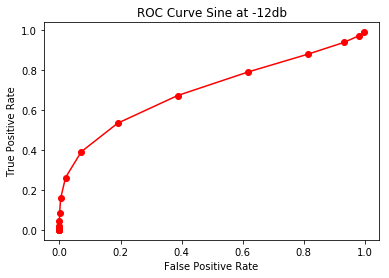

In [18]:
plt.plot(sine_p_fa, sine_p_d, '-o', color="red");
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve Sine at -12db');


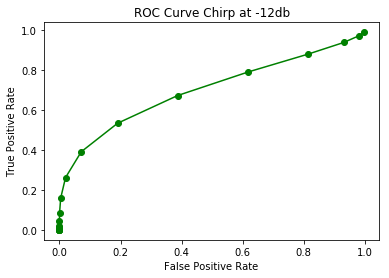

In [19]:
plt.plot(sine_p_fa, sine_p_d, '-o', color='green');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve Chirp at -12db');

### SNR = -13db Results
Here are the entropy scan results at -13db SNR for a sine needle.
![sineat-13](scan_results/-13db_i_sine_plots.png)

Here are the entropy scan results at -13db SNR for a sine needle.
![chirpat-13](scan_results/-13db_i_chirp_plots.png)

In [20]:
df = pd.read_csv('scan_results/-13db_i_results.csv', index_col=0)

sine_dist = df.loc[df.NeedleType =='sine']['norm_entropy']
min_sine = df.loc[df.NeedleType =='sine']['norm_entropy'].min()
max_sine = df.loc[df.NeedleType =='sine']['norm_entropy'].max()

chirp_dist = df.loc[df.NeedleType =='chirp']['norm_entropy']
min_chirp = df.loc[df.NeedleType =='chirp']['norm_entropy'].min()
max_chirp = df.loc[df.NeedleType =='chirp']['norm_entropy'].max()

noise_dist = df.loc[df.NeedleType =='noise']['norm_entropy']
min_noise = df.loc[df.NeedleType =='noise']['norm_entropy'].min()
max_noise = df.loc[df.NeedleType =='noise']['norm_entropy'].max()

mu_sine, std_sine = norm.fit(sine_dist)
mu_chirp, std_chirp = norm.fit(chirp_dist)
mu_noise, std_noise = norm.fit(noise_dist)

In [21]:
sine_thres = np.linspace(min_sine, max_sine, 20)
sine_p_d = []
sine_p_fa = []
for thres in sine_thres:
    a = min_sine
    b = thres
    sine_p_d.append(quad(lambda x: norm.pdf(x, loc = mu_sine, scale = std_sine), a, b)[0])
    sine_p_fa.append(quad(lambda x: norm.pdf(x, loc = mu_noise, scale = std_noise), a, b)[0])

chirp_thres = np.linspace(min_chirp, max_chirp, 20)
chirp_p_d = []
chirp_p_fa = []
for thres in chirp_thres:
    a = min_chirp
    b = thres
    chirp_p_d.append(quad(lambda x: norm.pdf(x, loc = mu_chirp, scale = std_chirp), a, b)[0])
    chirp_p_fa.append(quad(lambda x: norm.pdf(x, loc = mu_chirp, scale = std_chirp), a, b)[0])


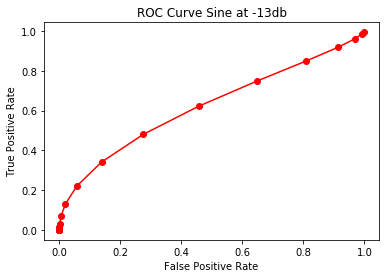

In [22]:
plt.plot(sine_p_fa, sine_p_d, '-o', color="red");
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve Sine at -13db');


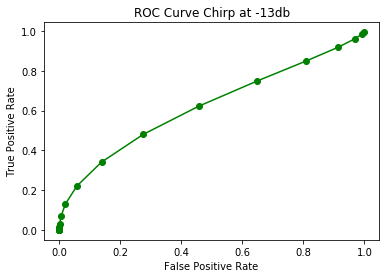

In [23]:
plt.plot(sine_p_fa, sine_p_d, '-o', color='green');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve Chirp at -13db');

### SNR = -15db Results
Here are the entropy scan results at -15db SNR for a sine needle.
![sineat-15](scan_results/-15db_i_sine_plots.png)

Here are the entropy scan results at -15db SNR for a sine needle.
![chirpat-15](scan_results/-15db_i_chirp_plots.png)

In [24]:
df = pd.read_csv('scan_results/-15db_i_results.csv', index_col=0)

sine_dist = df.loc[df.NeedleType =='sine']['norm_entropy']
min_sine = df.loc[df.NeedleType =='sine']['norm_entropy'].min()
max_sine = df.loc[df.NeedleType =='sine']['norm_entropy'].max()

chirp_dist = df.loc[df.NeedleType =='chirp']['norm_entropy']
min_chirp = df.loc[df.NeedleType =='chirp']['norm_entropy'].min()
max_chirp = df.loc[df.NeedleType =='chirp']['norm_entropy'].max()

noise_dist = df.loc[df.NeedleType =='noise']['norm_entropy']
min_noise = df.loc[df.NeedleType =='noise']['norm_entropy'].min()
max_noise = df.loc[df.NeedleType =='noise']['norm_entropy'].max()

mu_sine, std_sine = norm.fit(sine_dist)
mu_chirp, std_chirp = norm.fit(chirp_dist)
mu_noise, std_noise = norm.fit(noise_dist)

In [25]:
sine_thres = np.linspace(min_sine, max_sine, 20)
sine_p_d = []
sine_p_fa = []
for thres in sine_thres:
    a = min_sine
    b = thres
    sine_p_d.append(quad(lambda x: norm.pdf(x, loc = mu_sine, scale = std_sine), a, b)[0])
    sine_p_fa.append(quad(lambda x: norm.pdf(x, loc = mu_noise, scale = std_noise), a, b)[0])

chirp_thres = np.linspace(min_chirp, max_chirp, 20)
chirp_p_d = []
chirp_p_fa = []
for thres in chirp_thres:
    a = min_chirp
    b = thres
    chirp_p_d.append(quad(lambda x: norm.pdf(x, loc = mu_chirp, scale = std_chirp), a, b)[0])
    chirp_p_fa.append(quad(lambda x: norm.pdf(x, loc = mu_chirp, scale = std_chirp), a, b)[0])


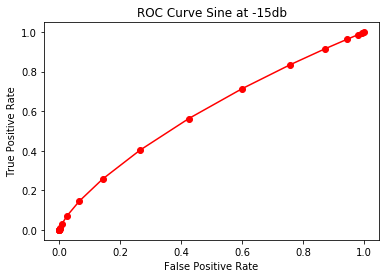

In [26]:
plt.plot(sine_p_fa, sine_p_d, '-o', color="red");
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve Sine at -15db');


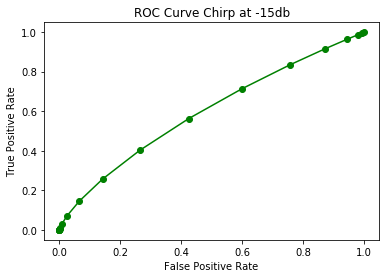

In [27]:
plt.plot(sine_p_fa, sine_p_d, '-o', color='green');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve Chirp at -15db');